![banner](https://storage.googleapis.com/kaggle-competitions/kaggle/5407/media/housesbanner.png)
# Preface
This kernel aims to show how I solve the "House price competition" and move to top 3% on the leaderboard. For each step, I comment out in detail why and how to do. If you need more explainations, please feel free to comment below and I will soon response. If you see that is kernel is helpful, please help me upvote it and share it with your friend (if they need). Thanks in advance!

# 1. Read train and test data
- Read train and test data which is store in csv to pandas dataframe.
- Create X and y as input for the model.

In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import pandas_profiling as pp
import missingno as msno
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None) 

# Read the datahome-data-for-ml-course/
X_full = pd.read_csv('../input/home-data-for-ml-course/train.csv', index_col='Id')
X_test_full = pd.read_csv('../input/home-data-for-ml-course/test.csv', index_col='Id')

# Remove rows with missing target, separate target from predictors
X_full.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X_full.SalePrice
X_full.drop(['SalePrice'], axis=1, inplace=True)

# 2. Explore data
- Explore missing data using missingno package
- Use pandas_profiling package to have an overview of data. Howevers, since it run a little slow, I comment it. If you need to rerun, uncomment and run it.
- Explore in detail some features that we can do feature engineering on them.

In [2]:
print('missing value:(missing count, total element,percentage)')
[{x:(X_full[x].isna().sum(),len(X_full.index),math.ceil(X_full[x].isna().sum()*100/len(X_full.index)*100)/100)} for x in X_full.columns[X_full.isna().any()]]

missing value:(missing count, total element,percentage)


[{'LotFrontage': (259, 1460, 17.74)},
 {'Alley': (1369, 1460, 93.77)},
 {'MasVnrType': (8, 1460, 0.55)},
 {'MasVnrArea': (8, 1460, 0.55)},
 {'BsmtQual': (37, 1460, 2.54)},
 {'BsmtCond': (37, 1460, 2.54)},
 {'BsmtExposure': (38, 1460, 2.61)},
 {'BsmtFinType1': (37, 1460, 2.54)},
 {'BsmtFinType2': (38, 1460, 2.61)},
 {'Electrical': (1, 1460, 0.07)},
 {'FireplaceQu': (690, 1460, 47.27)},
 {'GarageType': (81, 1460, 5.55)},
 {'GarageYrBlt': (81, 1460, 5.55)},
 {'GarageFinish': (81, 1460, 5.55)},
 {'GarageQual': (81, 1460, 5.55)},
 {'GarageCond': (81, 1460, 5.55)},
 {'PoolQC': (1453, 1460, 99.53)},
 {'Fence': (1179, 1460, 80.76)},
 {'MiscFeature': (1406, 1460, 96.31)}]

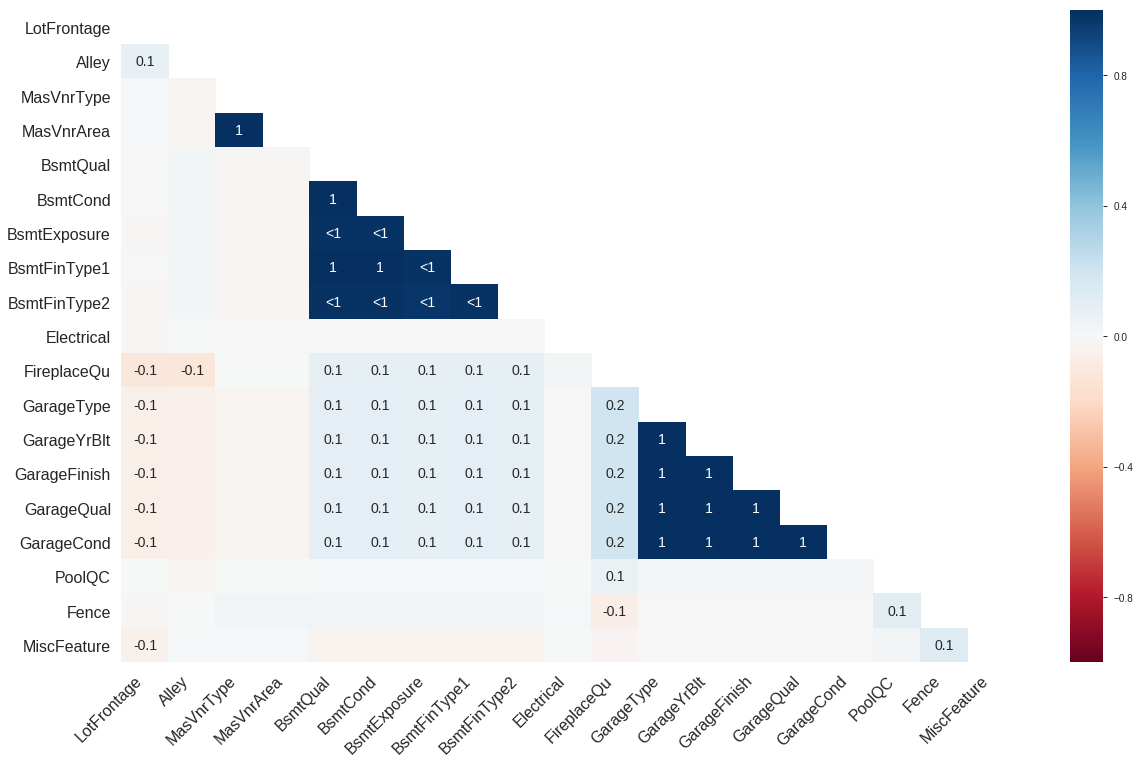

In [3]:
msno.heatmap(X_full)

In [4]:
# pp.ProfileReport(pd.concat([y,X_full], axis=1))

In [5]:
# This is skew cols we saw when profiling the data 
# skew_cols = ['1stFlrSF','BsmtUnfSF','GrLivArea','LotArea','OpenPorchSF','TotalBsmtSF']
# skew_cols = ['BsmtUnfSF','GrLivArea','LotArea','OpenPorchSF']
skew_cols = []

print(X_full['Exterior1st'].unique())
print(X_full['Exterior2nd'].unique())
print(X_full['Condition1'].unique())
print(X_full['Condition2'].unique())
print(X_full['FullBath'].unique())
print(X_full['HalfBath'].unique())
print(X_full['SaleType'].unique())
X_full[['Exterior1st','Exterior2nd','Condition1','Condition2','YearBuilt','YearRemodAdd','YrSold','GarageYrBlt']].head()

['VinylSd' 'MetalSd' 'Wd Sdng' 'HdBoard' 'BrkFace' 'WdShing' 'CemntBd'
 'Plywood' 'AsbShng' 'Stucco' 'BrkComm' 'AsphShn' 'Stone' 'ImStucc'
 'CBlock']
['VinylSd' 'MetalSd' 'Wd Shng' 'HdBoard' 'Plywood' 'Wd Sdng' 'CmentBd'
 'BrkFace' 'Stucco' 'AsbShng' 'Brk Cmn' 'ImStucc' 'AsphShn' 'Stone'
 'Other' 'CBlock']
['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']
[2 1 3 0]
[1 0 2]
['WD' 'New' 'COD' 'ConLD' 'ConLI' 'CWD' 'ConLw' 'Con' 'Oth']


,Exterior1st,Exterior2nd,Condition1,Condition2,YearBuilt,YearRemodAdd,YrSold,GarageYrBlt
Id,,,,,,,,
1,VinylSd,VinylSd,Norm,Norm,2003,2003,2008,2003.0
2,MetalSd,MetalSd,Feedr,Norm,1976,1976,2007,1976.0
3,VinylSd,VinylSd,Norm,Norm,2001,2002,2008,2001.0
4,Wd Sdng,Wd Shng,Norm,Norm,1915,1970,2006,1998.0
5,VinylSd,VinylSd,Norm,Norm,2000,2000,2008,2000.0


# 3. Change some numeric columns to categories since it looks like categories
- MSSubClass: The building class. This must be category, not numeric although it is storing as numeric
- MoSold: Month sold. Thinking about this: is it true that house price in Feb is double of Jan and price of Mar is triple of Jan? If it is not then we must change it to categories and must use OneHot Encoding to transform it.

In [6]:
# Convert numeric cols to categories
X_full['MSSubClass'] = X_full['MSSubClass'].apply(str)
X_test_full['MSSubClass'] = X_test_full['MSSubClass'].apply(str)

X_full['MoSold'] = X_full['MoSold'].apply(str)
X_test_full['MoSold'] = X_test_full['MoSold'].apply(str)

# Changing OverallCond into a categorical variable
# X_full['OverallCond'] = X_full['OverallCond'].astype(str)
# X_test_full['OverallCond'] = X_test_full['OverallCond'].astype(str)

# 4. Do feature engineering
**This step is an iteration. After calculate permuation importance, we try to explore new feature. The iteration end when we satisfy with the score :)**
- Exterior2nd is depends on Exterior1st so we merge Exterior1st and Exterior2nd to Exterior.
- Condition2 is depends on Condition1 so we merge Condition1 and Condition2 to Condition.
- Explore new feature which is importance for the model:
  + TotalSF: Total square feet of the whole house
  + TotalBathroom: Total bathroom of the whole house (include full bathroomo and half bathroom).


In [7]:
# Merge 'Exterior1st', 'Exterior2nd' to 'Exterior'
X_full['Exterior'] =  X_full.apply(lambda x: x['Exterior1st'] if (pd.isnull(x['Exterior2nd'])) else str(x['Exterior1st'])+'-'+str(x['Exterior2nd']), axis=1)
X_test_full['Exterior'] =  X_test_full.apply(lambda x: x['Exterior1st'] if (pd.isnull(x['Exterior2nd'])) else str(x['Exterior1st'])+'-'+str(x['Exterior2nd']), axis=1)
X_full.drop(['Exterior1st', 'Exterior2nd'],axis=1,inplace=True)
X_test_full.drop(['Exterior1st', 'Exterior2nd'],axis=1,inplace=True)

# Merge 'Condition1', 'Condition2' to 'Condition'
X_full['Condition'] =  X_full.apply(lambda x: x['Condition1'] if (pd.isnull(x['Condition2'])) else str(x['Condition1'])+'-'+str(x['Condition2']), axis=1)
X_test_full['Condition'] =  X_test_full.apply(lambda x: x['Condition1'] if (pd.isnull(x['Condition2'])) else str(x['Condition1'])+'-'+str(x['Condition2']), axis=1)
X_full.drop(['Condition1', 'Condition2'],axis=1,inplace=True)
X_test_full.drop(['Condition1', 'Condition2'],axis=1,inplace=True)

# Caculate YearRemodAdd and YrSold
# X_full['YearRemodAdd'] = X_full.apply(lambda x: x['YearRemodAdd'] - x['YearBuilt'], axis=1)
# X_full['GarageYrBlt'] = X_full.apply(lambda x: x['GarageYrBlt'] - x['YearBuilt'], axis=1)
# X_full['YrSold'] = X_full.apply(lambda x: x['YrSold'] - x['YearBuilt'], axis=1)

# X_test_full['YearRemodAdd'] = X_test_full.apply(lambda x: x['YearRemodAdd'] - x['YearBuilt'], axis=1)
# X_test_full['GarageYrBlt'] = X_test_full.apply(lambda x: x['GarageYrBlt'] - x['YearBuilt'], axis=1)
# X_test_full['YrSold'] = X_test_full.apply(lambda x: x['YrSold'] - x['YearBuilt'], axis=1)

# Generate total square
X_full['TotalSF'] = X_full['TotalBsmtSF'] + X_full['1stFlrSF'] + X_full['2ndFlrSF']
X_test_full['TotalSF'] = X_test_full['TotalBsmtSF'] + X_test_full['1stFlrSF'] + X_test_full['2ndFlrSF']
X_full.drop(columns=['TotalBsmtSF','1stFlrSF','2ndFlrSF'],axis=1,inplace=True)
X_test_full.drop(columns=['TotalBsmtSF','1stFlrSF','2ndFlrSF'],axis=1,inplace=True)

# # Generate total bathroom
X_full['TotalBathroom'] = 1*X_full['FullBath'] + X_full['HalfBath']
X_test_full['TotalBathroom'] = 1*X_test_full['FullBath'] + X_test_full['HalfBath']
X_full.drop(['FullBath', 'HalfBath'],axis=1,inplace=True)
X_test_full.drop(['FullBath', 'HalfBath'],axis=1,inplace=True)

# # Generate BsmtBath
# X_full['BsmtBath'] = X_full['BsmtHalfBath'] + 1.1*X_full['BsmtFullBath']
# X_test_full['BsmtBath'] = X_test_full['BsmtHalfBath'] + 1.1*X_test_full['BsmtFullBath']
# X_full.drop(['BsmtHalfBath', 'BsmtFullBath'],axis=1,inplace=True)
# X_test_full.drop(['BsmtHalfBath', 'BsmtFullBath'],axis=1,inplace=True)

# Generate TotalPorch
# X_full['TotalPorch'] = X_full['EnclosedPorch'] + X_full['SsnPorch'] + X_full['ScreenPorch']
# X_test_full['TotalPorch'] = X_test_full['EnclosedPorch'] + X_test_full['SsnPorch'] + X_test_full['ScreenPorch']
# X_full.drop(['EnclosedPorch','SsnPorch','ScreenPorch'],axis=1,inplace=True)
# X_test_full.drop(['EnclosedPorch','SsnPorch','ScreenPorch'],axis=1,inplace=True)

# Generate Bsmt
# X_full['Bsmt'] = X_full['BsmtCond'] + X_full['BsmtExposure'] + X_full['BsmtFinType1'] + X_full['BsmtFinType2']
# X_test_full['Bsmt'] = X_test_full['BsmtCond'] + X_test_full['BsmtExposure'] + X_test_full['BsmtFinType1'] + X_full['BsmtFinType2']
# X_full['BsmtFinType2'] =  X_full['BsmtFinType1'] + X_full['BsmtFinType2']
# X_test_full['BsmtFinType2'] =  X_test_full['BsmtFinType1'] + X_test_full['BsmtFinType2']
# X_full.drop(['BsmtFinType1','BsmtFinType2'],axis=1,inplace=True)
# X_test_full.drop(['BsmtFinType1','BsmtFinType2'],axis=1,inplace=True_HouseStyle


# Generagte BldgType_HouseStyle
# X_full['BldgType_HouseStyle'] = X_full['BldgType'] + '_' + X_full['HouseStyle']
# X_test_full['BldgType_HouseStyle'] = X_test_full['BldgType'] + '_' + X_test_full['HouseStyle']
# X_full.drop(['BldgType','HouseStyle'],axis=1,inplace=True)
# X_test_full.drop(['BldgType','HouseStyle'],axis=1,inplace=True)

# Merge PoolArea and PoolQC
# X_full['PoolQC'] = X_full['PoolQC'].map({'Ex':3,'Gd':2,'Fa':1})
# X_full['PoolQC'] = X_full['PoolQC'].fillna(0)
# X_test_full['PoolQC'] = X_test_full['PoolQC'].map({'Ex':3,'Gd':2,'Fa':1})
# X_test_full['PoolQC'] = X_test_full['PoolQC'].fillna(0)

# X_full.drop(columns=['PoolArea', 'PoolQC'],axis=1,inplace=True)
# X_test_full.drop(columns=['PoolArea', 'PoolQC'],axis=1,inplace=True)

# # Calculate log of SalePrice
# y = np.log(y)

# Drop columns that have too many missing value
X_full.drop(columns=['Alley','MiscFeature','PoolQC','PoolArea'],axis=1,inplace=True)
X_test_full.drop(columns=['Alley','MiscFeature','PoolQC','PoolArea'],axis=1,inplace=True)


In [8]:
# pp.ProfileReport(pd.concat([y,X_full], axis=1))

# 5. Choose type for each feature
- All columns with dtype int64, float64 will be numeric feature and others will be categories
- Seperate categories into large variety and small variety

In [9]:
# select caterical columns
categorical_cols = [cname for cname in X_full.columns if X_full[cname].dtype == "object"]
# Select numerical columns
numerical_cols = [cname for cname in X_full.columns if X_full[cname].dtype in ['int64', 'float64']]
X_full[numerical_cols].head(5)

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,YrSold,TotalSF,TotalBathroom
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,7,5,2003,2003,196.0,706,0,150,0,1710,1,0,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,2008,2566,3
2,80.0,9600,6,8,1976,1976,0.0,978,0,284,0,1262,0,1,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,2007,2524,2
3,68.0,11250,7,5,2001,2002,162.0,486,0,434,0,1786,1,0,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,2008,2706,3
4,60.0,9550,7,5,1915,1970,0.0,216,0,540,0,1717,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,2006,2473,1
5,84.0,14260,8,5,2000,2000,350.0,655,0,490,0,2198,1,0,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,2008,3343,3


In [10]:
print(sorted({x:X_full[x].nunique() for x in categorical_cols}.items(), key=lambda x: x[1],reverse=True))
X_full[categorical_cols].head(5)

[('Exterior', 67), ('Neighborhood', 25), ('Condition', 18), ('MSSubClass', 15), ('MoSold', 12), ('SaleType', 9), ('HouseStyle', 8), ('RoofMatl', 8), ('Functional', 7), ('RoofStyle', 6), ('Foundation', 6), ('BsmtFinType1', 6), ('BsmtFinType2', 6), ('Heating', 6), ('GarageType', 6), ('SaleCondition', 6), ('MSZoning', 5), ('LotConfig', 5), ('BldgType', 5), ('ExterCond', 5), ('HeatingQC', 5), ('Electrical', 5), ('FireplaceQu', 5), ('GarageQual', 5), ('GarageCond', 5), ('LotShape', 4), ('LandContour', 4), ('MasVnrType', 4), ('ExterQual', 4), ('BsmtQual', 4), ('BsmtCond', 4), ('BsmtExposure', 4), ('KitchenQual', 4), ('Fence', 4), ('LandSlope', 3), ('GarageFinish', 3), ('PavedDrive', 3), ('Street', 2), ('Utilities', 2), ('CentralAir', 2)]


,MSSubClass,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,BldgType,HouseStyle,RoofStyle,RoofMatl,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,Fence,MoSold,SaleType,SaleCondition,Exterior,Condition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,1Fam,2Story,Gable,CompShg,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,NaN,2,WD,Normal,VinylSd-VinylSd,Norm-Norm
2,20,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,1Fam,1Story,Gable,CompShg,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,5,WD,Normal,MetalSd-MetalSd,Feedr-Norm
3,60,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,1Fam,2Story,Gable,CompShg,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,9,WD,Normal,VinylSd-VinylSd,Norm-Norm
4,70,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,1Fam,2Story,Gable,CompShg,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,NaN,2,WD,Abnorml,Wd Sdng-Wd Shng,Norm-Norm
5,60,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,1Fam,2Story,Gable,CompShg,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,12,WD,Normal,VinylSd-VinylSd,Norm-Norm


In [11]:
print(sorted({x:X_full[x].nunique() for x in numerical_cols}.items(), key=lambda x: x[1],reverse=True))
print(X_full['MSSubClass'].unique())
X_full[numerical_cols].head(5)

[('LotArea', 1073), ('TotalSF', 963), ('GrLivArea', 861), ('BsmtUnfSF', 780), ('BsmtFinSF1', 637), ('GarageArea', 441), ('MasVnrArea', 327), ('WoodDeckSF', 274), ('OpenPorchSF', 202), ('BsmtFinSF2', 144), ('EnclosedPorch', 120), ('YearBuilt', 112), ('LotFrontage', 110), ('GarageYrBlt', 97), ('ScreenPorch', 76), ('YearRemodAdd', 61), ('LowQualFinSF', 24), ('MiscVal', 21), ('3SsnPorch', 20), ('TotRmsAbvGrd', 12), ('OverallQual', 10), ('OverallCond', 9), ('BedroomAbvGr', 8), ('GarageCars', 5), ('YrSold', 5), ('TotalBathroom', 5), ('BsmtFullBath', 4), ('KitchenAbvGr', 4), ('Fireplaces', 4), ('BsmtHalfBath', 3)]
['60' '20' '70' '50' '190' '45' '90' '120' '30' '85' '80' '160' '75' '180'
 '40']


,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,YrSold,TotalSF,TotalBathroom
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,7,5,2003,2003,196.0,706,0,150,0,1710,1,0,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,2008,2566,3
2,80.0,9600,6,8,1976,1976,0.0,978,0,284,0,1262,0,1,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,2007,2524,2
3,68.0,11250,7,5,2001,2002,162.0,486,0,434,0,1786,1,0,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,2008,2706,3
4,60.0,9550,7,5,1915,1970,0.0,216,0,540,0,1717,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,2006,2473,1
5,84.0,14260,8,5,2000,2000,350.0,655,0,490,0,2198,1,0,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,2008,3343,3


In [12]:
# Break off validation set from training data
# X_train_full, X_valid_full, y_train, y_valid = train_test_split(X_full, y, 
#                                                                 train_size=0.8, test_size=0.2,
#                                                                 random_state=0)

categorical_small_variety_cols = [cname for cname in X_full.columns if
                    X_full[cname].nunique() <= 15 and
                    X_full[cname].dtype == "object"]

categorical_large_variety_cols = [cname for cname in X_full.columns if
                    X_full[cname].nunique() > 15 and
                    X_full[cname].dtype == "object"]

# categorical_l_cols = [cname for cname in X_full.columns if
#                     X_full[cname].nunique() > 10 and 
#                     X_full[cname].nunique() <= 15 and 
#                     X_full[cname].dtype == "object"]
categorical_label_cols = []

print('numerical_cols: ',numerical_cols)
print('categorical_cols: ',categorical_cols)
print('categorical_label_cols: ',categorical_label_cols )
print('categorical_small_variety_cols: ', categorical_small_variety_cols)
print('categorical_large_variety_cols: ',categorical_large_variety_cols)

numerical_cols:  ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MiscVal', 'YrSold', 'TotalSF', 'TotalBathroom']
categorical_cols:  ['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'Fence', 'MoSold', 'SaleType', 'SaleCondition', 'Exterior', 'Condition

In [13]:
from sklearn.pipeline import Pipeline, TransformerMixin
from sklearn.neighbors import LocalOutlierFactor

class OutlierExtractor(TransformerMixin):
    def __init__(self, **kwargs):
        """
        Create a transformer to remove outliers. A threshold is set for selection
        criteria, and further arguments are passed to the LocalOutlierFactor class

        Keyword Args:
            neg_conf_val (float): The threshold for excluding samples with a lower
               negative outlier factor.

        Returns:
            object: to be used as a transformer method as part of Pipeline()
        """
        try:
            self.threshold = kwargs.pop('neg_conf_val')
        except KeyError:
            self.threshold = -10.0
        pass
        self.kwargs = kwargs

    def transform(self, X):
        """
        Uses LocalOutlierFactor class to subselect data based on some threshold

        Returns:
            ndarray: subsampled data

        Notes:
            X should be of shape (n_samples, n_features)
        """
        x = np.asarray(X)
        lcf = LocalOutlierFactor(**self.kwargs)
        lcf.fit(X)
        return x[lcf.negative_outlier_factor_ > self.threshold, :]

    def fit(self, *args, **kwargs):
        return self

# 6. Create pipeline

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
import category_encoders as ce
from xgboost import XGBRegressor

# Preprocessing for numerical data
numerical_transformer = Pipeline(verbose=False,steps=[
    ('imputer_num', SimpleImputer(strategy='median')),
#     ('remove_outlier', OutlierExtractor())
])

# Preprocessing for categorical data
categorical_onehot_transformer = Pipeline(verbose=False,steps=[
    ('imputer_onehot', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

categorical_label_transformer = Pipeline(verbose=False,steps=[
    ('imputer_label', SimpleImputer(strategy='most_frequent')),
    ('label', ce.OrdinalEncoder())
    
])

categorical_count_transformer = Pipeline(verbose=False,steps=[
    ('imputer_count', SimpleImputer(strategy='most_frequent')),
    ('count', ce.TargetEncoder(handle_missing='count'))
#     ('count', ce.CountEncoder(min_group_size = 1,handle_unknown=0,handle_missing='count'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(verbose=False,
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cox_box', PowerTransformer(method='yeo-johnson', standardize=False),skew_cols),
        ('cat_label', categorical_label_transformer, categorical_label_cols),
        ('cat_onehot', categorical_onehot_transformer, categorical_small_variety_cols),
        ('cat_count', categorical_count_transformer, categorical_large_variety_cols),
    ])

train_pipeline = Pipeline(verbose=False,steps=[
                    ('preprocessor', preprocessor),   
                    ('scale', StandardScaler(with_mean=True,with_std=True)),
                    ('model', XGBRegressor(random_state=0))
                    ])

# 7. Calculate importance of each feature to iterate feature engineering
- Use Permutation Importance to calculate how important of each feature and use it in the iteration of feature engineering

In [15]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display

# Split dataset to train and test
X_train, X_valid, y_train, y_valid = train_test_split(X_full[numerical_cols], y,train_size=0.8, test_size=0.2,random_state=0)

# Define pipeline to do transformation
transform_pipeline = Pipeline(verbose=False,steps=[
                    ('imputer_num', SimpleImputer(strategy='median')),
                    ('scale', StandardScaler(with_mean=True,with_std=True)),
                    ])

# Transform data
transform_pipeline.fit(X_train,y_train)
pi_X_train = pd.DataFrame(transform_pipeline.transform(X_train))
pi_X_valid = pd.DataFrame(transform_pipeline.transform(X_valid))
pi_X_train.columns = X_train.columns
pi_X_valid.columns = X_valid.columns

# Define a model and calculate permutation importance of all numeric columns
pi_model = RandomForestRegressor(n_estimators=700,max_depth=4,random_state=0)
pi_model.fit(pi_X_train,y_train)
perm = PermutationImportance(pi_model, random_state=1).fit(pi_X_valid, y_valid)
eli5.show_weights(perm, feature_names = pi_X_valid.columns.tolist(),top=100)

/opt/conda/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.


Weight,Feature
0.5960 ± 0.1295,TotalSF
0.3379 ± 0.0493,OverallQual
0.0195 ± 0.0038,YearBuilt
0.0059 ± 0.0014,BsmtFinSF1
0.0053 ± 0.0015,YearRemodAdd
0.0038 ± 0.0009,GarageCars
0.0024 ± 0.0003,KitchenAbvGr
0.0022 ± 0.0003,TotalBathroom
0.0022 ± 0.0004,LotArea
0.0020 ± 0.0033,GarageArea


# 8. Train the model
- Use XGBoost to train to model
- Using GridSearchCV to search for best hyper parameter of XGBoost

PS: You can add more parameters. I keep small range of params to make it run faster in Kaggle.

In [16]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV

param_grid = {'model__nthread':[2], #when use hyperthread, xgboost may become slower
              'model__learning_rate': [0.04, 0.05], #so called `eta` value
              'model__max_depth': range(3,5,1),
#               'model__importance_type': ['weight', 'gain', 'cover'],
#               "model__min_child_weight" : [ 1 ],
#               "model__gamma"            : [ 0.0],
              "model__colsample_bytree" : [ 0.2 ],
              'model__silent': [1],
              'model__n_estimators': [700], #number of trees
#               'model__n_estimators': range(595,600,1), #number of trees
#               'model__n_estimators': range(550,1000,5), #number of trees
             }
searched_model = GridSearchCV(estimator=train_pipeline,param_grid = param_grid, scoring="neg_mean_absolute_error", cv=5, error_score='raise', verbose = 1)
searched_model.fit(X_full,y)

print(searched_model.best_estimator_)
print(searched_model.best_score_)


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   35.4s finished


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer_num',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                         

# 9. Predict using the best model
- Predict the model with best hyper parameter
- Create result to submit to leaderboard

In [17]:
preds_test = searched_model.predict(X_test_full)
# Save test predictions to file
output = pd.DataFrame({'Id': X_test_full.index,'SalePrice': preds_test})
output.to_csv('submission.csv', index=False)
output

,Id,SalePrice
0,1461,119298.742188
1,1462,156270.906250
2,1463,188783.578125
3,1464,199999.140625
4,1465,190473.109375
...,...,...
1454,2915,84669.757812
1455,2916,82906.523438
1456,2917,160205.359375
1457,2918,122985.078125
